# Определение возраста покупателей по фото

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

**Цель проекта:** постройте модель, которая по фотографии определит приблизительный возраст человека.

**Требования:** метрика $MAE$ меньше **7**.

**Описание данных:** папка со всеми изображениями `/datasets/faces/final_files` и CSV-файл `/datasets/faces/labels.csv` с двумя колонками: `file_name` и `real_age`.

## Библиотеки и функции

In [1]:
# !pip install -U matplotlib -q
# !pip install -U seaborn -q
# !pip install -U pandas -q
# !pip install -U jinja2 -q
# !pip install -U scikit-learn -q

# !pip install -U torch
# !pip install torchvision
# !pip install torchinfo

In [2]:
import os
import time
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, recall_score

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import v2
from torchvision import models

from torchinfo import summary

sns.set_style('whitegrid')
sns.set_palette('muted')

In [3]:
class UnNormalize(v2.Normalize):
    """
    Действие, обратное нормализации.
    Класс принимает на вход два кортежа mean и std.
    """
    
    def __init__(self,mean, std, *args, **kwargs):
        new_mean = [-m/s for m,s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

In [4]:
def hist_chart(data, ax, title=''):
    sns.histplot(data=data, ax=ax, kde=True, bins=data.nunique())
    ax.axvline(x=data.median(), color='black', alpha=.5, label=f'median ({data.median():.2f})')
    ax.axvline(x=data.mean(), color='black', alpha=.5, label=f'mean ({data.mean():.2f})', linestyle='dashed')
    ax.set(title=title, xlabel='age', ylabel='count')
    ax.legend()


def box_chart(data, ax, title=''):
    sns.boxplot(data=data, ax=ax, boxprops={'alpha': .5}, orient='y')
    ax.set(title=title, xlabel='age', ylabel='')

In [5]:
def image_grid(data, pred=None, descending_residuals=False, title='', seed=None):
    """
    - Если из аргументов указан только data - функция вернёт случаный набор 
    изображений. Возможно зафиксировать параметр seed для воспроизводимости результата.
    - Если указаны data и pred (предсказания модели), то функция вернет случаный набор 
    изображений, для каждого из которых будет указан реальный и предсказанный возраст. 
    Так же можно зафиксировать seed.
    - Если вместе с pred установить descending_residuals=True, то функция вернёт 
    изображения, отсортированные по убыванию ошибки предсказания. Полезно, что бы оценить, 
    на каких фотографиях модель ошибается наиболее сильно.
    """
    
    if pred is not None and descending_residuals:
        true = data['real_age'].to_numpy()
        pred = pred.numpy()
        residuals = abs(true - pred)
        idx_list = residuals.argsort()[::-1][:24]
    else:
        idx_list = np.random.RandomState(seed).randint(len(data), size=24)
    
    fig, axes = plt.subplots(3, 8, figsize=(15, 6))
    fig.suptitle(title, fontweight='bold')
    for ax, idx in zip(axes.flat, idx_list):
        img, label = data.loc[idx]
        img = Image.open(os.path.join(PATH, 'final_files', img))

        if pred is not None:
            label_pred = pred[idx].item()
            label = f'{label}  ({label_pred:.1f})'

        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.show()

In [6]:
def viewing_transforms(data, data_source, seed=None):
    """
    Функция принимает на вход сформированный Dataset pyTroch и исходный датафрейм.
    Возвращает случайное исходное изображение в первой ячейке; а в остальных ячейках
    вернуться случайные аугментации данного изображения.
    Параметр seed фиксирует выбор конкретного изображения. Аугментации каждый раз
    отображаются случайные.
    """

    unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    idx = np.random.RandomState(seed).randint(len(data))

    img_source_name = data_source.loc[idx, 'file_name']
    img_source = Image.open(os.path.join(PATH, 'final_files', img_source_name))
    
    title = f'age: {data[idx][1]}   ({img_source_name})'

    fig, axes = plt.subplots(3, 8, figsize=(15, 6))
    fig.suptitle(title)
    for ax in axes.flat:
        img = data[idx][0]
        # Отменим операцию нормализации для изображения, что бы они корректно отображались
        img = unnorm(img).numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.axis('off')

    axes[0, 0].imshow(img_source)
    axes[0, 0].set_title(f'source\n{np.array(img_source).shape}')
    axes[0, 1].set_title(f'transforms\n{img.shape}')
    
    plt.show()

In [7]:
def residuals_chart(true, pred, title=''):
    """
    Графики для анализа остатков.
    """
    # true = true.flatten().cpu()
    # pred = pred.flatten().cpu()
    residuals = (true - pred)
    
    fig, ax = plt.subplots(3, figsize=(11, 14))
    fig.suptitle(title, fontweight='bold', y=.92)
    sns.histplot(residuals, kde=True, ax=ax[0])
    ax[0].axvline(x=residuals.median(), color='black', alpha=.8, label=f'median ({residuals.median():.2f})')
    ax[0].axvline(x=residuals.mean(), color='black', alpha=.8, label=f'mean ({residuals.mean():.2f})', linestyle='dashed')
    ax[0].legend()
    ax[0].set_ylabel('count')
    ax[0].set_xlabel('residuals')
    
    sns.scatterplot(y=true, x=residuals, ax=ax[1], s=15, alpha=.7)
    ax[1].set_ylabel('true age')
    ax[1].set_xlabel('residuals')

    sns.scatterplot(y=true, x=pred, ax=ax[2], s=15, alpha=.7)
    ax[2].plot([0, true.max()], [0, true.max()], color='black')
    ax[2].set_ylabel('true age')
    ax[2].set_xlabel('pred age')

    plt.show()

In [8]:
# Constants
SEED = 42

PATH = '/datasets/faces'
if not os.path.exists(PATH):
    PATH = '../../../datasets/appa_real_release'
print(f"PATH = '{PATH}'")

EPOCHS = 30
BATCH_SIZE = 16

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'pyTorch use: \033[32m\033[1m{DEVICE}\033[0m', f'({torch.cuda.get_device_name()})' if torch.cuda.is_available() else '')

PATH = '../../../datasets/appa_real_release'
pyTorch use: cuda (AMD Radeon RX 7800 XT)


## Исследовательский анализ данных

In [9]:
data = pd.read_csv(os.path.join(PATH, 'labels.csv'))  # index_col=[0]

In [10]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 177.9+ KB


In [12]:
data.isna().sum()

file_name    0
real_age     0
dtype: int64

In [13]:
data['file_name'].duplicated().sum()

0

Имеем датасет, в котором 7591 фотография. Если судить по названиям изображений в csv файле, то дубликаты отсутствуют.  
Взглянем на распределение фото по возрастам.

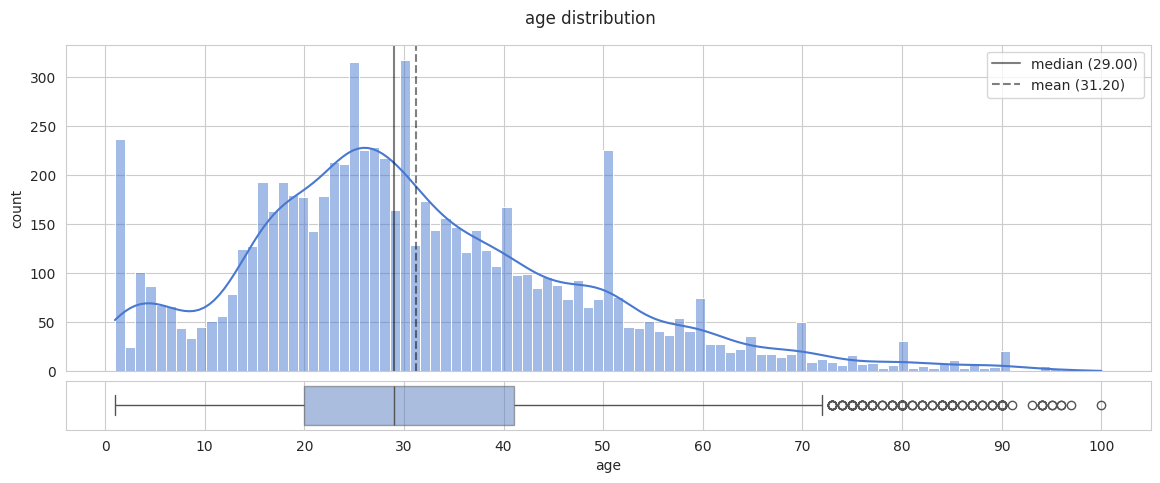

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


In [14]:
fig, ax = plt.subplots(2, figsize=(14, 5), sharex=True, gridspec_kw={"height_ratios": (1, .15)})
fig.suptitle('age distribution', y=.95)
hist_chart(data['real_age'], ax[0])
box_chart(data['real_age'], ax[1])
plt.xticks(range(0, 101, 10))
plt.subplots_adjust(hspace=.05)
plt.show()

data.describe().T

Распределение скошено вправо; фотографий пожилых людей в датасете представлено достаточно мало, что не позволит модели хорошо предсказывать возраст у данной группы населения. Скорее всего будет наблюдаться тенденция на занижение возраста для пожилых.  
Так же на многих круглых датах наблюдаются пики, что позволяет сделать вывод о том, что по крайней в ряде случаев целевой признак дан с округлением. Это так же негативно скажется на точности модели.

Рассмотрим примеры фотографий из датасета с указанием возраста.

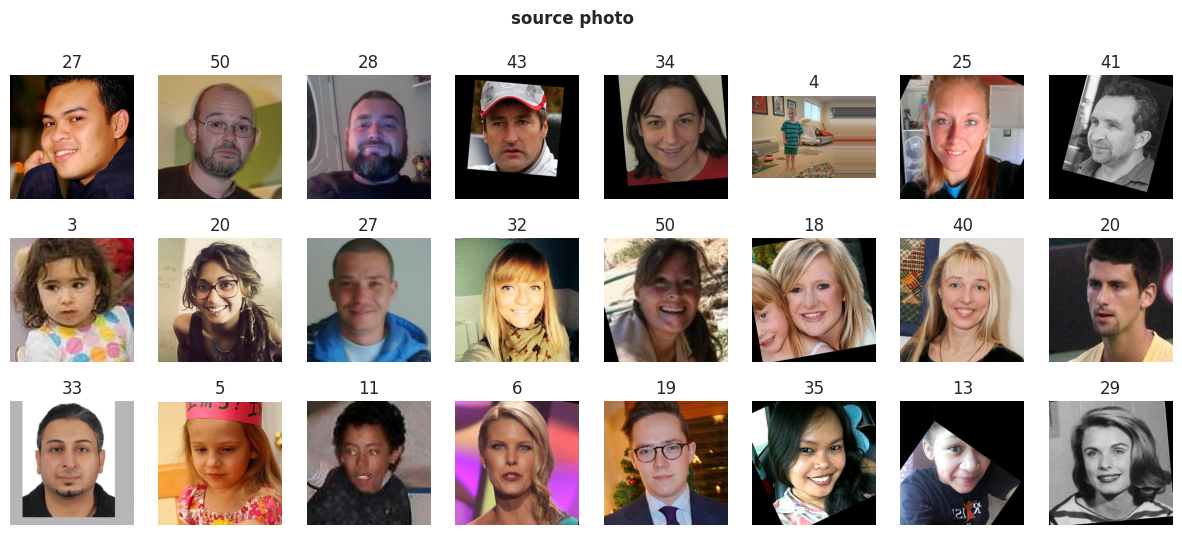

In [15]:
image_grid(data, title='source photo', seed=42)

Фотографии в основном цветные, но встречаются и чб. Некоторые фото изначально обрезаны и повернуты, скорее всего для их предварительной обработки использовалась нейросеть, которая в ряде случаев сделала только хуже, например обрезав часть лица (как на втором фото справа снизу). На некоторых фото присуствуют более одного человека - в таких случаях модель будет вести себя непредсказуемо.

## Подготовка данных

Разделим данные на три выборки. Для тренировки используем 70% датасета. Для валидации и теста по 15%.

In [16]:
train, test = train_test_split(data, random_state=SEED, train_size=.7)
valid, test = train_test_split(test, random_state=SEED, train_size=.5)

train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

In [17]:
pd.DataFrame({
    'train': train.shape[0],
    'valid': valid.shape[0],
    'test': test.shape[0]
}, index=['size']).T

,size
train,5313
valid,1139
test,1139


Взглянем на на распределение возрастов в каждой выборке.

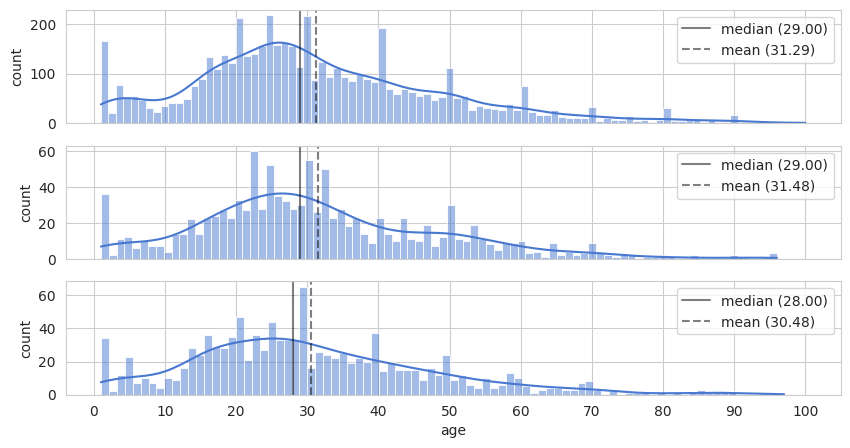

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(10, 5), sharex=True)
hist_chart(train['real_age'], ax[0])
hist_chart(valid['real_age'], ax[1])
hist_chart(test['real_age'], ax[2])
plt.xticks(range(0, 101, 10))
plt.show()

Датасет относительно маленький, поэтому распределение между выборками несколько отличается.

Преобразуем класс Dataset из pyTorch под наши данные.

In [19]:
class MakeDataset(Dataset):
    def __init__(self, data, path, transform=None):
        self.data = data
        self.path = path
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        img_path = os.path.join(self.path, self.data.iloc[idx]['file_name'])
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx]['real_age']
        if self.transform:
            image = self.transform(image)
        return image, label

Все изображения приведем к единому размеру 224x224, так как модель Resnet, которую мы применим, использует данный формат. Так же используем нормализацию со средним и стандартным отклонением, которые рекомендуются в [документации](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50).

Для тренировочных данных дополнительно будем применять случайные аугментации, воспользуемся готовым набором `AutoAugmentPolicy.IMAGENET`, и дополним его небольшим вращением на угол до 10 градусов и зеркальным отражением.

In [20]:
transform_train = v2.Compose([
    v2.ToImage(), 
    v2.Resize(240),
    v2.AutoAugment(policy=v2.AutoAugmentPolicy.IMAGENET),
    v2.RandomRotation(10),
    v2.RandomHorizontalFlip(),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])


transform = v2.Compose([
    v2.Resize(232),
    v2.CenterCrop(224),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])


train_data = MakeDataset(train, os.path.join(PATH, 'final_files'), transform=transform_train)
valid_data = MakeDataset(valid, os.path.join(PATH, 'final_files'), transform=transform)
test_data = MakeDataset(test, os.path.join(PATH, 'final_files'), transform=transform)

Взглянем на случайную фотографию и на ее возможные варианты преобразований.  
При каждом обращении к объекту Dataset будет возвращаться случайное преобразование, что даст возможность модели не переобучиться, так как каждую эпоху она будет получать на вход немного измененные картинки.

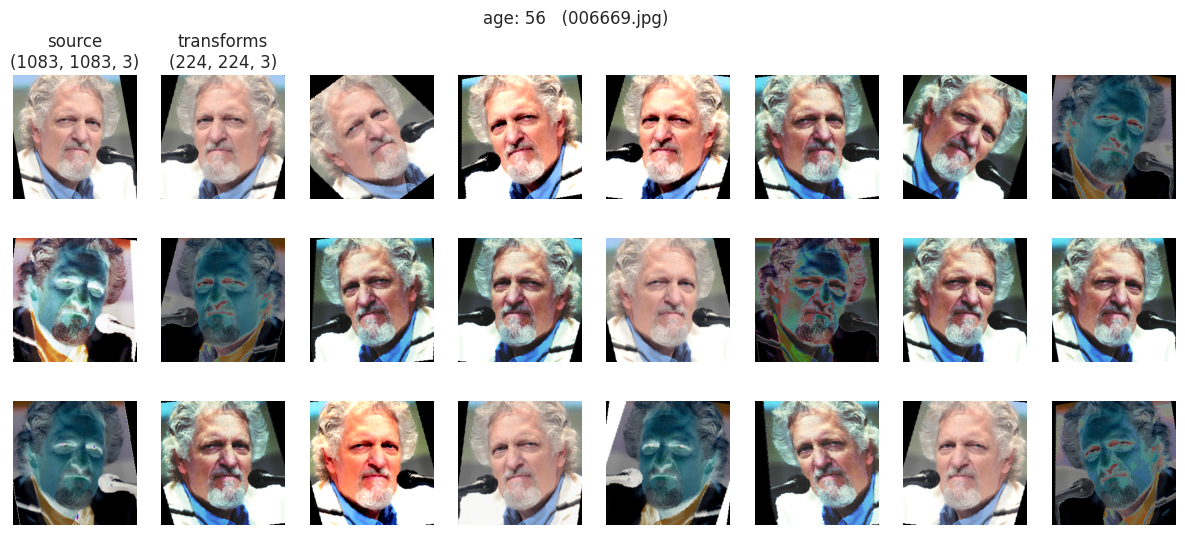

In [21]:
viewing_transforms(train_data, train, seed=189)

Убедимся, что размер готовых датасетов совпадает с исходными выборками.

In [22]:
print('len train_data:', len(train_data))
print('len valid_data:', len(valid_data))
print('len test_data: ', len(test_data))

print('\ntensor size:', train_data[0][0].shape)

len train_data: 5313
len valid_data: 1139
len test_data:  1139

tensor size: torch.Size([3, 224, 224])


Далее сформируем объекты DataLoader, что позволит обучать модель батчами. Для тренировочных данных будем использовать случайное перемешивание.

In [23]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

Взглянем на количество получившихся батчей для каждой выборки. В каждом батче содержится 16 изображений.

In [24]:
print('batches in train_loader:', len(train_loader))
print('batches in valid_loader:', len(valid_loader))
print('batches in test_loader: ', len(test_loader))

print('\nbatch size:', next(iter(train_loader))[0].shape)

batches in train_loader: 333
batches in valid_loader: 72
batches in test_loader:  72

batch size: torch.Size([16, 3, 224, 224])


## Обучение

Напишем несколько вспомогательных функций для тренировки и тестирования.

In [25]:
def model_train(model, loader, device, criterion, metric, optimizer):
    loss_list, score_list = [], []

    model.train()
    loop = tqdm(loader, bar_format='{percentage:3.0f}%{bar}{n_fmt}/{total_fmt}   {desc}')
    for X, y in loop:
        X = X.to(device)
        y = y.float().reshape(-1, 1).to(device)

        optimizer.zero_grad()
        predict = model(X)
        loss = criterion(predict, y)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.item())
        loss_mean = np.mean(loss_list)

        score = metric(predict, y)
        score_list.append(score.item())
        score_mean = np.mean(score_list)

        loop_description = f'train_loss: {loss_mean:.4f}, train_mae: {score_mean:.4f}'
        loop.set_description(loop_description)

    return loss_mean, score_mean

In [26]:
def model_eval(model, loader, device, criterion, metric, return_y=False):
    y_true = torch.FloatTensor([]).to(device)
    y_pred = torch.FloatTensor([]).to(device)
    model.eval()
    with torch.no_grad():
        loop = tqdm(loader, desc='evaluation', bar_format='{percentage:3.0f}%{bar}{n_fmt}/{total_fmt}   {desc}')
        for X, y in loop:
            X = X.to(device)
            y = y.float().reshape(-1, 1).to(device)
            predict = model(X)
    
            y_true = torch.cat([y_true, y])
            y_pred = torch.cat([y_pred, predict])

    loss = criterion(y_pred, y_true).item()
    score = metric(y_pred, y_true).item()
    
    if return_y:
        return loss, score, y_true.flatten().cpu(), y_pred.flatten().cpu()
    else:
        return loss, score

In [27]:
class SaveModel():
    """
    Сохранение модели в файл или переменную.
    """
    def __init__(self, model, optimizer, scheduler, train_log):
        self.checkpoint = {
            'info': {
                'datetime': time.ctime(time.time()),
                **train_log.iloc[-1].to_dict()
            },
            'train_log': train_log,
            'state_model': model.state_dict(),
            'state_optimizer': optimizer.state_dict(),
            'state_scheduler': scheduler.state_dict()
    }

    def file(self, path):
        torch.save(self.checkpoint, path)

    def variable(self):
        return copy.deepcopy(self.checkpoint)

Как уже писалось ранее, в качестве модели воспользуемся `ResNet50` с уже обученными весами, которая изначально применяется для классификации изображений на 1000 классов. Остается только изменить выходные слои под нашу задачу.

In [28]:
model = models.resnet50(weights='IMAGENET1K_V2').to(DEVICE)

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Dropout(.2),
    nn.Linear(128, 1),
    nn.ReLU()
).to(DEVICE)

summary(model, (BATCH_SIZE, 3, 224, 224), depth=2, device=DEVICE, col_names=['output_size', 'num_params', 'trainable'])

/home/lake/anaconda3/envs/lime/lib/python3.9/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:288.)
  return F.linear(input, self.weight, self.bias)


Layer (type:depth-idx)                   Output Shape              Param #                   Trainable
ResNet                                   [16, 1]                   --                        True
├─Conv2d: 1-1                            [16, 64, 112, 112]        9,408                     True
├─BatchNorm2d: 1-2                       [16, 64, 112, 112]        128                       True
├─ReLU: 1-3                              [16, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [16, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [16, 256, 56, 56]         --                        True
│    └─Bottleneck: 2-1                   [16, 256, 56, 56]         75,008                    True
│    └─Bottleneck: 2-2                   [16, 256, 56, 56]         70,400                    True
│    └─Bottleneck: 2-3                   [16, 256, 56, 56]         70,400                    True
├─Sequential: 1-6  

В качестве функции потерь будем использовать $MSE$, дополнительно будем рассчитывать метрику $MAE$. Обучать сеть будем с помощью оптимизатора `Adam`. Если метрика перестанет уменьшаться, то скорость обучения будет автоматически снижаться с помощью планировщика `ReduceLROnPlateau`.

In [29]:
# Датафрейм для записи лога обучения
train_log = pd.DataFrame()

criterion = nn.MSELoss()
metric = F.l1_loss
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=.2, patience=4, threshold=.001)

Цикл обучения и валидации:

In [30]:
# Начальное значение метрики на валидации, ниже которого найчнем сохранять лучшие модели
best_score = 6.5

for epoch in range(EPOCHS):

    # Training
    start = time.time()
    train_loss_mean, train_score_mean = model_train(model, train_loader, DEVICE, criterion, metric, optimizer)
    train_time = time.time() - start

    # Validation
    valid_loss, valid_score = model_eval(model, valid_loader, DEVICE, criterion, metric)

    # Scheduler
    scheduler.step(valid_score)

    # Log
    train_log.loc[epoch, 'epoch'] = f'[{epoch+1}/{EPOCHS}]'
    train_log.loc[epoch, 'time, s'] = train_time
    train_log.loc[epoch, 'lr'] = scheduler.get_last_lr()[0]
    train_log.loc[epoch, 'train_loss'] = train_loss_mean
    train_log.loc[epoch, 'train_score'] = train_score_mean
    train_log.loc[epoch, 'valid_loss'] = valid_loss
    train_log.loc[epoch, 'valid_score'] = valid_score

    # Save best model
    if valid_score < best_score:
        train_log.loc[epoch, 'save'] = 'true'
        best_score = valid_score
        save_model = SaveModel(model, optimizer, scheduler, train_log)
        best_model = save_model.variable()  # saving the best model to a variable
        save_model.file('model_age_determination.pt')  # saving to a file

    # Display results
    display((
        train_log
        .style
        .format(precision=4, na_rep='')
        .format('{:.1e}', subset=['lr'])
        .format(precision=0, subset=['time, s'])
        .format('<b>{:.4f}</b>', subset=['valid_score'])
        ), clear=True)

,epoch,"time, s",lr,train_loss,train_score,valid_loss,valid_score,save
0,[1/30],43,1.0e-04,320.1412,13.1206,100.0477,7.6002,
1,[2/30],42,1.0e-04,126.5279,8.5967,126.7172,8.9381,
2,[3/30],42,1.0e-04,107.4456,7.8161,103.6131,7.4925,
3,[4/30],42,1.0e-04,93.2381,7.3432,81.5268,6.7990,
4,[5/30],41,1.0e-04,80.7440,6.8191,76.4791,6.5005,
5,[6/30],41,1.0e-04,72.0359,6.4891,88.5793,6.9339,
6,[7/30],42,1.0e-04,67.3762,6.2205,76.1728,6.6748,
7,[8/30],42,1.0e-04,63.5408,6.0619,83.3622,6.9015,
8,[9/30],42,1.0e-04,58.1456,5.8118,70.8958,6.2836,true
9,[10/30],42,1.0e-04,57.2239,5.7516,79.9886,6.5280,


<div style="border-radius: 7px; padding: 10px; border: 1px solid; background-color:#ede8ff">
<b>Комментарий:</b><br>
    
Ссылка на обученную модель: [GoogleDrive](https://drive.google.com/drive/folders/1xs9d1PpYTze-lOovbDmZGGeDgda0OPCV?usp=sharing).
</div>

Во время обучения модель может в какой то момент переобучиться, и метрика на валидации упадет по сравнению с предыдущими эпохами. Поэтому в цикле обучения мы каждый раз обновляли переменную, содержащею веса лучшей модели, если метрика улучшалась. Теперь подргузим эти веса, дающие лучшую оценку на валидационной выборке.

In [31]:
# Раскоментить при необходимости подргузить модель из файла
# best_model= torch.load('model_age_determination.pt', map_location=DEVICE)

In [32]:
# Загрузка лучших весов в модель
model.load_state_dict(best_model['state_model'])
print('\033[32mThe best model has been uploaded. Info:\033[0m')
display(best_model['info'])

The best model has been uploaded. Info:


{'datetime': 'Mon Jul 22 18:54:03 2024',
 'epoch': '[29/30]',
 'time, s': 40.725467920303345,
 'lr': 2e-05,
 'train_loss': 20.79868407292409,
 'train_score': 3.408065784800876,
 'valid_loss': 59.202728271484375,
 'valid_score': 5.616237640380859,
 'save': 'true'}

Посмотрим на то, как изменялись метрики и скорость обучения в зависимости от эпохи.

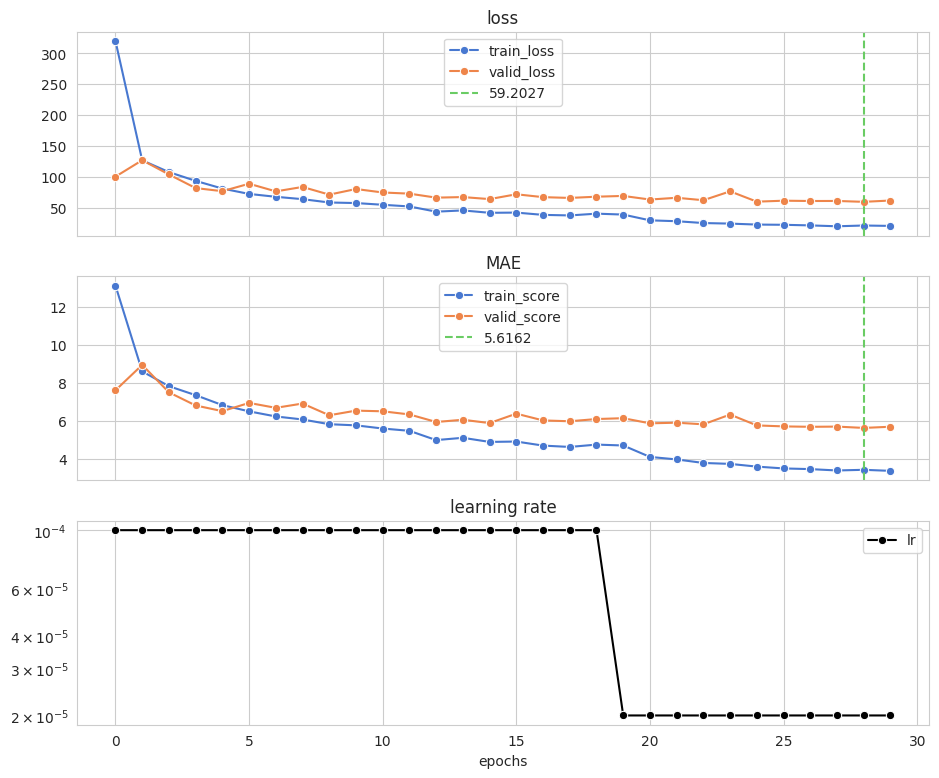

In [33]:
fig, ax = plt.subplots(3, figsize=(11, 9), sharex=True)

sns.lineplot(train_log[['train_loss', 'valid_loss']], dashes=False, markers=['o', 'o'], ax=ax[0])
ax[0].axvline(x=train_log['valid_loss'].idxmin(), color='C2', linestyle='dashed', label=f"{train_log['valid_loss'].min():.4f}")
ax[0].set_title('loss')
ax[0].legend()

sns.lineplot(train_log[['train_score', 'valid_score']], dashes=False, markers=['o', 'o'], ax=ax[1])
ax[1].axvline(x=train_log['valid_score'].idxmin(), color='C2', linestyle='dashed', label=f"{train_log['valid_score'].min():.4f}")
ax[1].set_title('MAE')
ax[1].legend()

sns.lineplot(train_log[['lr']], dashes=False, markers='o', ax=ax[2], palette=['black'])
ax[2].semilogy()
ax[2].set_title('learning rate')
ax[2].set_xlabel('epochs')
plt.show()

На первых двух графиках видим постепенное снижение значений метрик и на тесте и на валидации; есть небольшие всплески на нескольких эпохах, но в целом, модель обучилась хорошо. Явного переобучения не наблюдается. Наилучшее значение $MAE$ = **5.6162** мы получили на 29 эпохе из 30.

Взглянем на то, как распределены ошибки предсказаний.

  0%          0/72   evaluation

valid_loss: 59.2027, valid_mae: 5.6162 


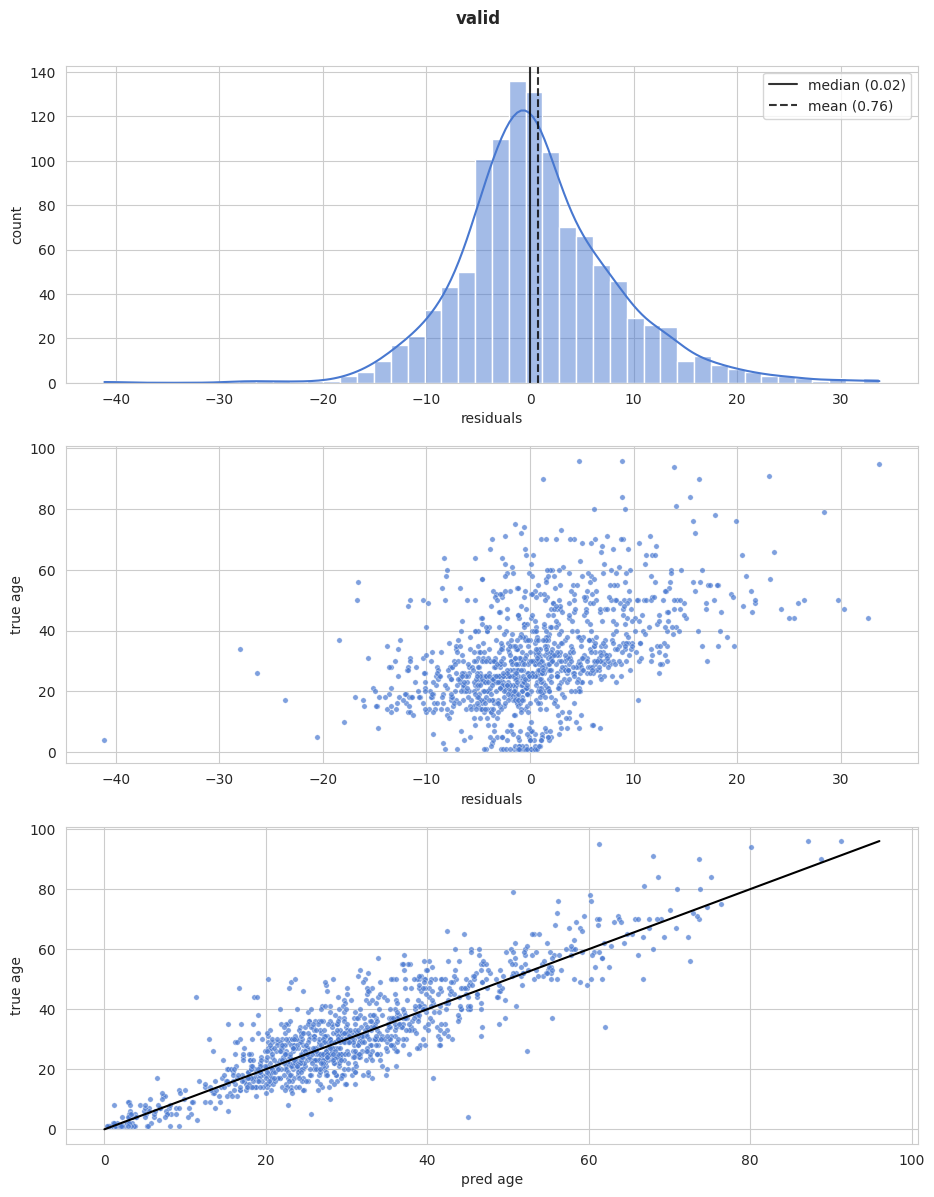

In [34]:
valid_loss, valid_score, valid_true, valid_pred = model_eval(model, valid_loader, DEVICE, criterion, metric, return_y=True)
print(f'valid_loss: {valid_loss:.4f}, valid_mae: \033[1m{valid_score:.4f}\033[0m ')

residuals_chart(valid_true, valid_pred, 'valid')

По первому графику видно, что распределение остатков похоже на нормальное распределение - это хорошо. Но среднее значение немного смещено вправо относительно нуля - это говорит о том, что модель склонна занижать возраст.  
На втором графике можно наблюдать остатки для каждого отдельного наблюдения. Мы видим рассеянное облако точек справа сверху, это означает, что для самых возрастных групп населения модель дает довольно хаотичные предсказания (преимущественно занижая возраст), так как примеров для обучения в выборке было недостаточно что бы уловить все закономерности.  
Третий график, по сути, немного другое представление второго. Точки находящиеся выше черной линии - это предсказания с заниженным возрастом, а те, что под линией, соответственно, с завышенным.

## Тестирование

Настало время протестировать модель на тестовой выборке.

  0%          0/72   evaluation

test_loss: 55.3310, test_mae: 5.5388 


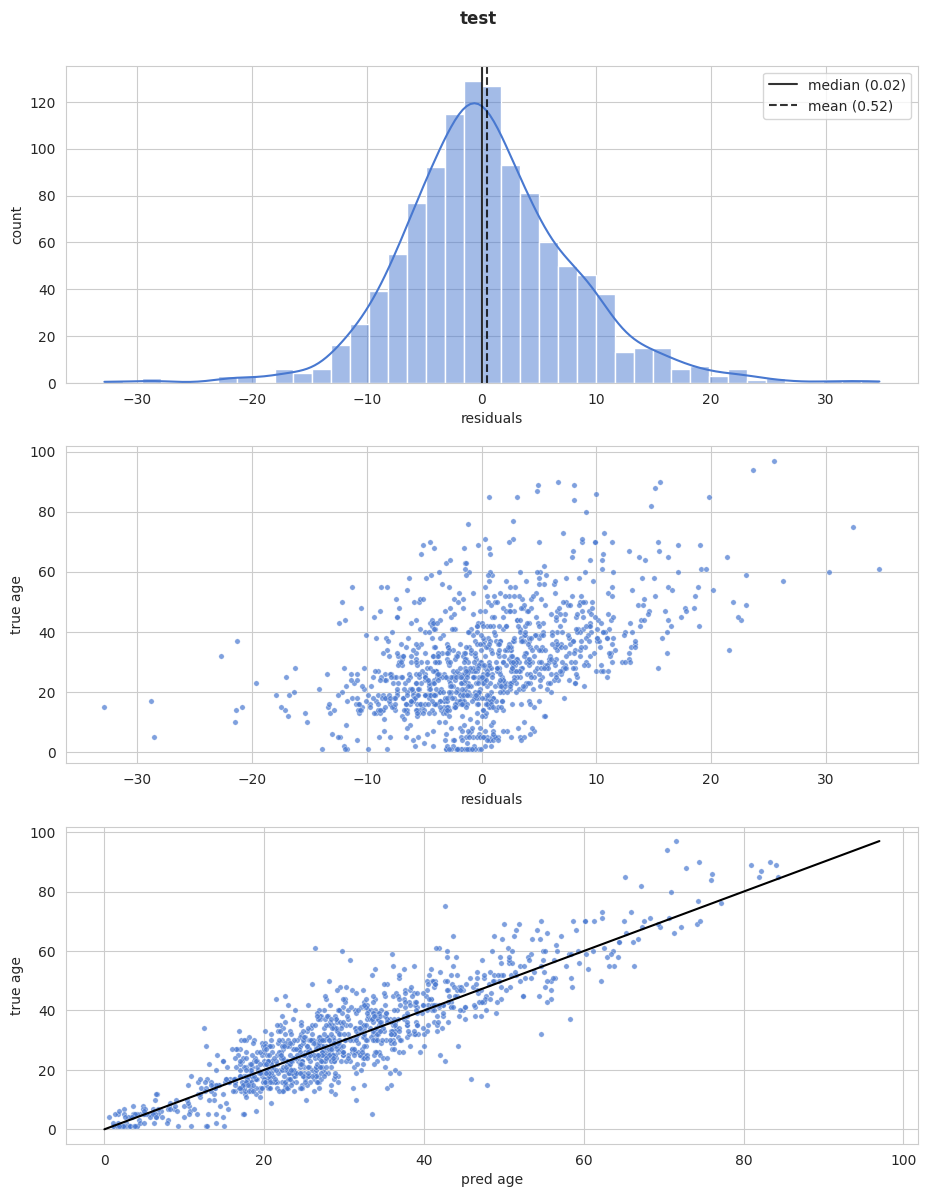

In [35]:
test_loss, test_score, test_true, test_pred = model_eval(model, test_loader, DEVICE, criterion, metric, return_y=True)
print(f'test_loss: {test_loss:.4f}, test_mae: \033[1m{test_score:.4f}\033[0m ')

residuals_chart(test_true, test_pred, 'test')

На тестовых данных мы получили значение метрики $MAE$ = **5.5388**, что удовлетворяет критериям заказчика.  
Положение дел на графиках почти такое же, как на валидации - модель занижает возраст у людей старшего поколения. Так же есть несколько выбросов, которые можно видеть на втором графике слева снизу; это случаи, когда модель сильно завысила возраст.

Взглянем на фотографии, на которых модель ошиблась наиболее сильно. Сначала идет исходный возраст, а в скобках - предсказанный моделью.

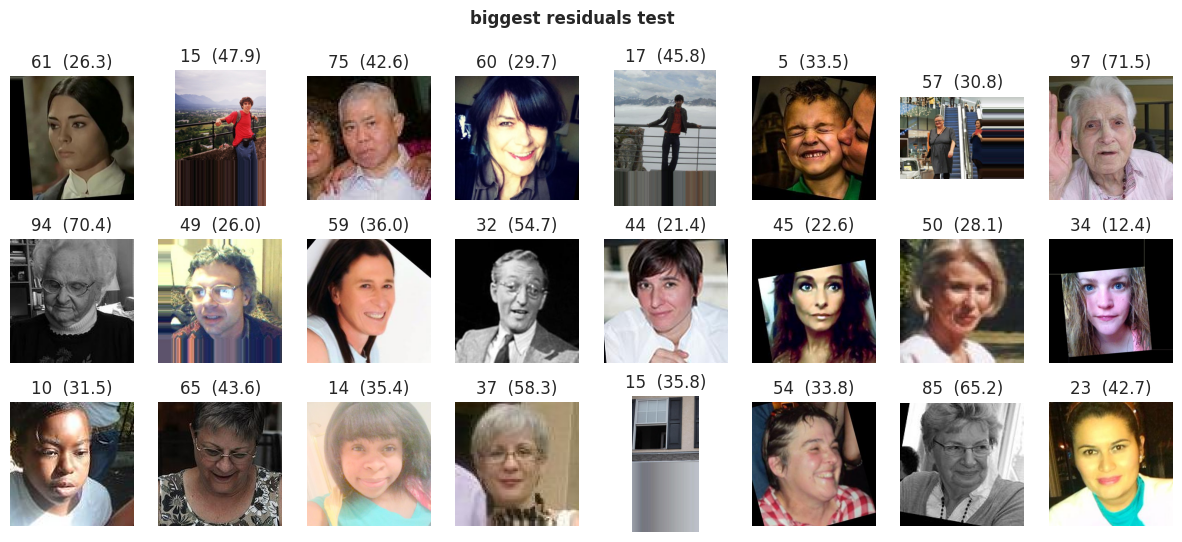

In [36]:
image_grid(test, test_pred, descending_residuals=True, title='biggest residuals test')

Рассмотрим несколько примеров и попытаемся предположить причину сильной ошибки.
- На первом фото молодая девушка, у которой явно неправильно был указан исходный возраст (либо на фотографии помимо нее были еще люди, которые обрезались при первичной обработке, сделанной до нас) - тут модель предсказала возраст адекватно.
- На втором фото модель ошиблась из за того, что человек на фото сильно удален, в датасете в основном портреты с близкого расстояния.
- На третьем фото в кадре несколько человек.
- На пятом фото человек так же сильно удален.
- На шестом фото в кадре так же несколько человек. В датасете в основном представлены нейтральные выражения лиц, а на шестом фото у мальчика яркая эмоция. Скорее всего это так же внесло вклад в ошибку.

Дополнительно проверим, как полученная модель справится с классификацией людей на тех кому больше и меньше 18 лет; так как одна из задач подразумевает *"контролировать добросовестность кассиров при продаже алкоголя"*.  
Использовать предсказания регрессионной модели для классификации - это неправильно, но мы попробуем.  
Тех, кому нет 18 лет - отметим как `True`, а тех кто старше - `False`.

In [37]:
test_true_18 = test_true < 18
test_pred_18 = test_pred < 18

Оценим метрику recall, потому что в данном случае нам более важны ошибки второго рода, так как лучше переспросить паспорт у совершеннолетнего, чем продать алкоголь подростку. Так же взглянем на матрицу ошибок.

Recall: 0.6375

Confusion matrix:


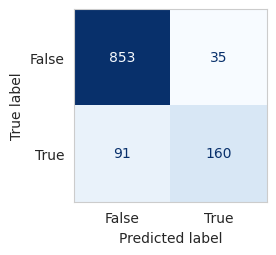

In [38]:
print(f'Recall: {recall_score(test_true_18, test_pred_18):.4f}')
print('\nConfusion matrix:')
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ConfusionMatrixDisplay.from_predictions(test_true_18, test_pred_18, ax=ax, cmap='Blues', colorbar=False) # display_labels=['under 18 ', 'over 18']
plt.grid(False)
plt.show()

Как и ожидалось, с подобной задачей модель справилась довольно плохо. Примерно 36% несовершеннолетних идентифицировались моделью, как совершеннолетние.  
Для следующих задач:
- анализ покупок и предложение товаров, которые могут заинтересовать покупателей этой возрастной группы;
- контроль добросовестности кассиров при продаже алкоголя.

оптимальным решением было бы обучить две разные модели, первая - регрессионная, которую мы сделали. А вторая для бинарной классификации с подбором порога для минимизации ошибок второго рода.

## Выводы

В ходе проекта была разработана модель для определения примерного возраста человека по фотографии. Для корректной работы полученная модель должна принимать на вход фото, на котором изображен только один человек. На практике этого можно добиться, если дополнительно применить модель, обученную на задачу детекции человеческих лиц.
Значение метрики на тестовой выборки получилось $MAE$ = **5.5388**, что удовлетворяет поставленным условиям.

Для сценария использования, в котором по примерному возрасту формируется список предложений, которые потенциально могут заинтересовать человека данной возрастной группы - модель подойдет довольно хорошо. Но для контроля добросовестности кассиров при продаже алкоголя необходим немного другой подход, в котором применяется модель для классификации.